In [6]:
# !pip install --upgrade google-cloud-aiplatform
GCP_PROJECT= PROJECT_ID=project_id='my-project-0004-346516'
LOCATION = REGION = 'us-central1'

In [7]:
# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [8]:
from vertexai.preview.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)

In [9]:
multimodal_model = GenerativeModel("gemini-pro-vision")


### Define helper functions


In [10]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_images([content])
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_multimodal_prompt(contents: list[str | Image | Part]):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)

### Generating a video description


Gemini 
### https://cloud.google.com/vertex-ai/pricing
$0.002 / second

For 60 seconds -video prices- 0.12$

In [11]:
prompt = """
What is shown in this video?
Where should I go to see it?
What are the top 5 places in the world that look like this?
"""
video = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/mediterraneansea.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------

What is shown in this video?
Where should I go to see it?
What are the top 5 places in the world that look like this?




-------Response--------
 The video shows a beautiful coastline with a city on a cliff. The water is a crystal-clear blue and green, and the waves are crashing against the shore. The city is full of white buildings and there is a long pier with a lighthouse at the end.

You can see this in Antalya, Turkey.

The top 5 places in the world that look like this are:

1. Santorini, Greece
2. Positano, Italy
3. Amalfi Coast, Italy
4. Cinque Terre, Italy
5. Dubrovnik, Croatia

In [9]:
!gsutil ls gs://my-project-0004-346516/matchingengine/Videos/*.mp4

gs://my-project-0004-346516/matchingengine/Videos/butterflies_1280.mp4
gs://my-project-0004-346516/matchingengine/Videos/butterflies_960p.mp4
gs://my-project-0004-346516/matchingengine/Videos/elefant_1280p.mp4
gs://my-project-0004-346516/matchingengine/Videos/giraffes_1280p.mp4
gs://my-project-0004-346516/matchingengine/Videos/seafood_1280p.mp4


In [10]:
prompt = """
What is shown in this video?
Where should I go to see it?
What are the top 5 types of items that we see here?
"""

video_list = ["gs://my-project-0004-346516/matchingengine/Videos/butterflies_1280.mp4",
"gs://my-project-0004-346516/matchingengine/Videos/butterflies_960p.mp4",
"gs://my-project-0004-346516/matchingengine/Videos/elefant_1280p.mp4",
"gs://my-project-0004-346516/matchingengine/Videos/giraffes_1280p.mp4",
"gs://my-project-0004-346516/matchingengine/Videos/seafood_1280p.mp4"]

for i in range(0, len(video_list)) :
    print("Here is the video number",i, video_list[i])
    video = Part.from_uri( uri=video_list[i],
    mime_type="video/mp4",)
    contents = [prompt, video]
    
    responses = multimodal_model.generate_content(contents, stream=True)

    print("-------Prompt--------")
    print_multimodal_prompt(contents)

    print("\n-------Response--------")
    for response in responses:
        print(response.text, end="")

-------Prompt--------

What is shown in this video?
Where should I go to see it?
What are the top 5 types of items that we see here?




-------Response--------
 A butterfly garden.
A butterfly conservatory or a botanical garden.
1. Monarch
2. Blue Morpho
3. Tiger Swallowtail
4. Painted Lady
5. Cabbage White-------Prompt--------

What is shown in this video?
Where should I go to see it?
What are the top 5 types of items that we see here?




-------Response--------
 A variety of butterflies are shown in this video.
You can see butterflies in many places around the world. Some good places to see them are butterfly gardens, nature centers, and rainforests.
The top 5 types of butterflies in the video are:
1. Blue Morpho
2. Monarch
3. Tiger Swallowtail
4. Painted Lady
5. Cabbage White-------Prompt--------

What is shown in this video?
Where should I go to see it?
What are the top 5 types of items that we see here?




-------Response--------
 A family of elephants crossing a river.
You can see this in many national parks and reserves in Africa.
1. Elephants
2. Water
3. Trees
4. Bushes
5. Sand-------Prompt--------

What is shown in this video?
Where should I go to see it?
What are the top 5 types of items that we see here?




-------Response--------
 The video shows two giraffes in the African savanna. You can see giraffes in many African countries, including Kenya, Tanzania, Botswana, Zambia, and South Africa.

The top 5 types of items that we see here are:

1. Giraffes
2. Trees
3. Bushes
4. Grass
5. Sky-------Prompt--------

What is shown in this video?
Where should I go to see it?
What are the top 5 types of items that we see here?




-------Response--------
 This is a video of a Japanese fish market. It’s located in the city of Osaka. The market is famous for its fresh seafood. There are many different types of fish and shellfish available. You can also find other types of seafood, such as octopus and squid.

The top 5 types of items that we see here are:

1. Clams
2. Scallops
3. Shrimp
4. Crab
5. Squid

### Convert Images into Video

In [22]:
import cv2
import os
import glob


### Default way

In [19]:
def create_video(image_folder, video_name, fps):
    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg") or img.endswith(".png")]
    print(images)
    images.sort()  # Ensure images are in the correct order
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, fps, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()

In [20]:
# Example usage:
image_folder = './images/'
video_name = 'my_video.avi'
fps = 2  # Frames per second
create_video(image_folder, video_name, fps)

['03_MTV-1950.png', '03 GPT-3 Test Invalid Positive Result - has additional quality.png', '4pyP5p8zkHfE8qy.png', '01_CH-ZRH-EURH-02.png', '5EiR875XPajWBRF.png', '01_CH-ZRH-EURH.png', '3BKop8N6zk7S8ik.png', '5PLzGvyVdf2zk6c.png', '5H2cC8WKfBusJ39.png', '5HoGsB4q9GNK9cX.png', '5da67cf3-7627-41fa-946f-efd5c821ba50_3de48c45-c6b5-43e3-b6e9-46b8962a65be.png', '5nBQudiYU4eRqXF.png']


In [13]:
from IPython.display import Video

Video('my_video.avi') 

### Resize and create video

In [29]:
# Set the desired video properties
fps = 1  # Frames per second
width = 640  # Video width
height = 480  # Video height
image_folder = './images/tiger-512/'

# Get a list of image files in the directory
image_files = glob.glob(os.path.join(image_folder, "*.png"))

# Sort the image files in ascending order
image_files.sort(key=os.path.getmtime)

# Resize all images to the same size
resized_images = []
for image_file in image_files:
    image = cv2.imread(image_file)
    resized_image = cv2.resize(image, (width, height))
    resized_images.append(resized_image)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [30]:
print(image_files)

['./images/tiger-512/00000021_512resized.png', './images/tiger-512/00000003_512resized.png', './images/tiger-512/00000041_512resized.png', './images/tiger-512/00000017_512resized.png', './images/tiger-512/00000011_512resized.png', './images/tiger-512/00000039_512resized.png', './images/tiger-512/00000019_512resized.png', './images/tiger-512/00000027_512resized.png', './images/tiger-512/00000010_512resized.png', './images/tiger-512/00000000_512resized.png', './images/tiger-512/00000044_512resized.png', './images/tiger-512/00000037_512resized.png', './images/tiger-512/00000022_512resized.png', './images/tiger-512/00000047_512resized.png', './images/tiger-512/00000038_512resized.png', './images/tiger-512/00000018_512resized.png', './images/tiger-512/00000016_512resized.png', './images/tiger-512/00000054_512resized.png', './images/tiger-512/00000051_512resized.png', './images/tiger-512/00000029_512resized.png', './images/tiger-512/00000002_512resized.png', './images/tiger-512/00000024_512r

In [31]:
# Create a video writer object
size = (640, 480)
video_name = 'my_video.avi' 

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(video_name, fourcc, fps, size)

# Write the images to the video
for image in resized_images:
    video_writer.write(image)

# Release the video writer object
video_writer.release()

In [32]:
from IPython.display import Video

Video(video_name) 

### lets use Imagen and modify one image for few things and create a few copies of that to really create a movie

In [1]:
# from vertexai.preview.vision_models import ImageGenerationModel



In [1]:
import os
import vertexai
from vertexai.preview.language_models import TextGenerationModel
from vertexai.preview.generative_models import GenerativeModel, Part
Region = "us-centra1"
GCP_PROJECT= PROJECT_ID=project_id='my-project-0004-346516'

vertexai.init()

def generate_pro(input_prompt):
    model = GenerativeModel("gemini-pro")
    responses = model.generate_content(
    input_prompt,
    generation_config={
        "max_output_tokens": 2048,
        "temperature": 0.2,
        "top_p": 1
    },stream=True,)
    
    all_response  = []
    
    for response in responses:
        all_response.append(response.text)
    
    # print (all_response)
    
    return(" ".join(all_response))

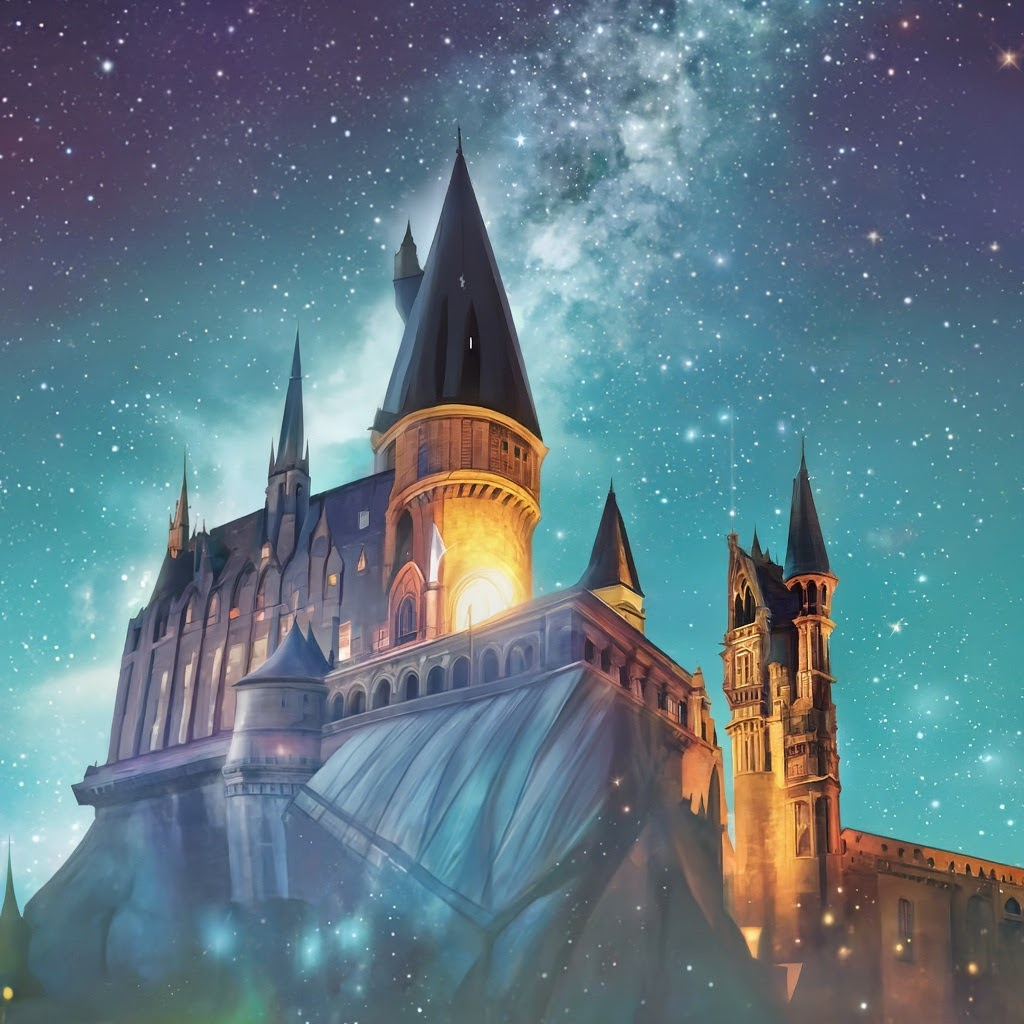

In [47]:
imagen_model = ImageGenerationModel.from_pretrained("imagegeneration@002")

input_question = "What is a quote from Harry Potter and the Sorcerer's Stone"
system_prompt = " Convert this question to a meaning prompt for imagen model to create a good image - in photography style"

prompt = input_question + " " + system_prompt
image_prompt = generate_pro(prompt)

response = imagen_model.generate_images(
    prompt=image_prompt,
)

response.images[0].show()
response.images[0].save(location="./images/tiger-modified/gen-imagen.png")

del(imagen_model )

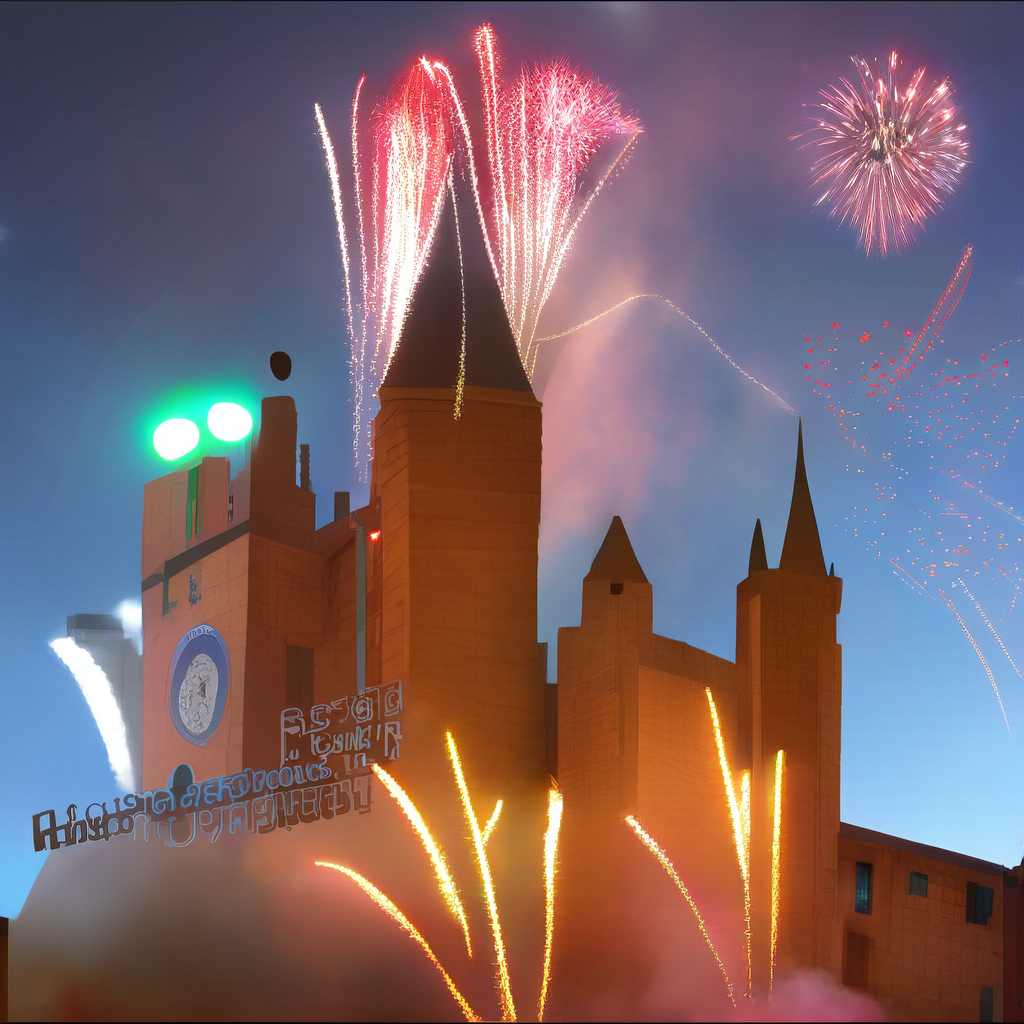

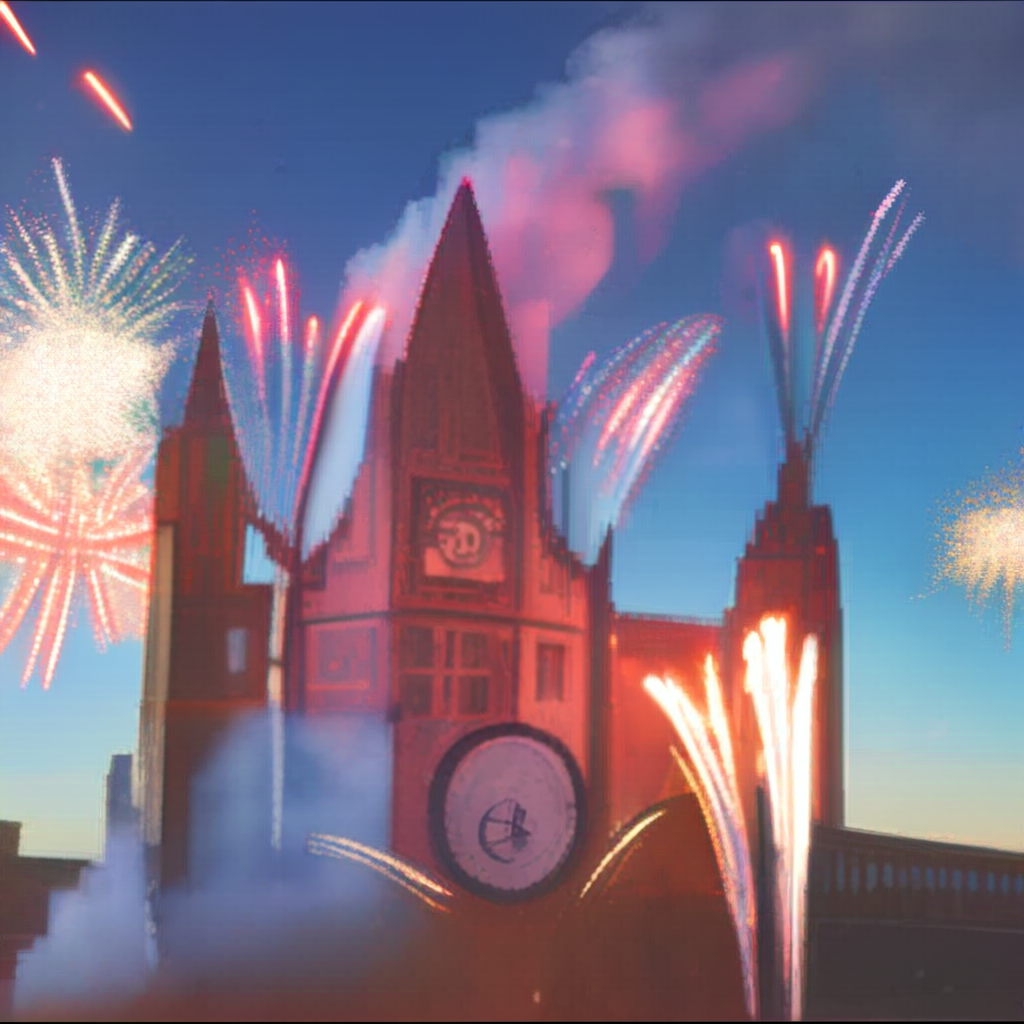

In [48]:
import vertexai
from vertexai.preview.vision_models import Image, ImageGenerationModel

model = ImageGenerationModel.from_pretrained("imagegeneration@002")
# base_img=Image.load_from_file(location='./images/tiger-512/00000000_512resized.png')
base_img=Image.load_from_file(location='./images/tiger-modified/gen-imagen.png')



images = model.edit_image(
  base_image=base_img,
  prompt="add fireworks",
  # negativePrompt = "red colour",
  # Optional:
  seed=0,
  guidance_scale=21,
  number_of_images=4
)

images[0].save(location="./images/tiger-modified/edit-img1.png")
images[1].save(location="./images/tiger-modified/edit-img2.png")
images[2].save(location="./images/tiger-modified/edit-img3.png")
# images[3].save(location="./images/tiger-modified/edit-img4.png")

# Optional. View the edited images in a notebook.
images[0].show()
images[1].show()

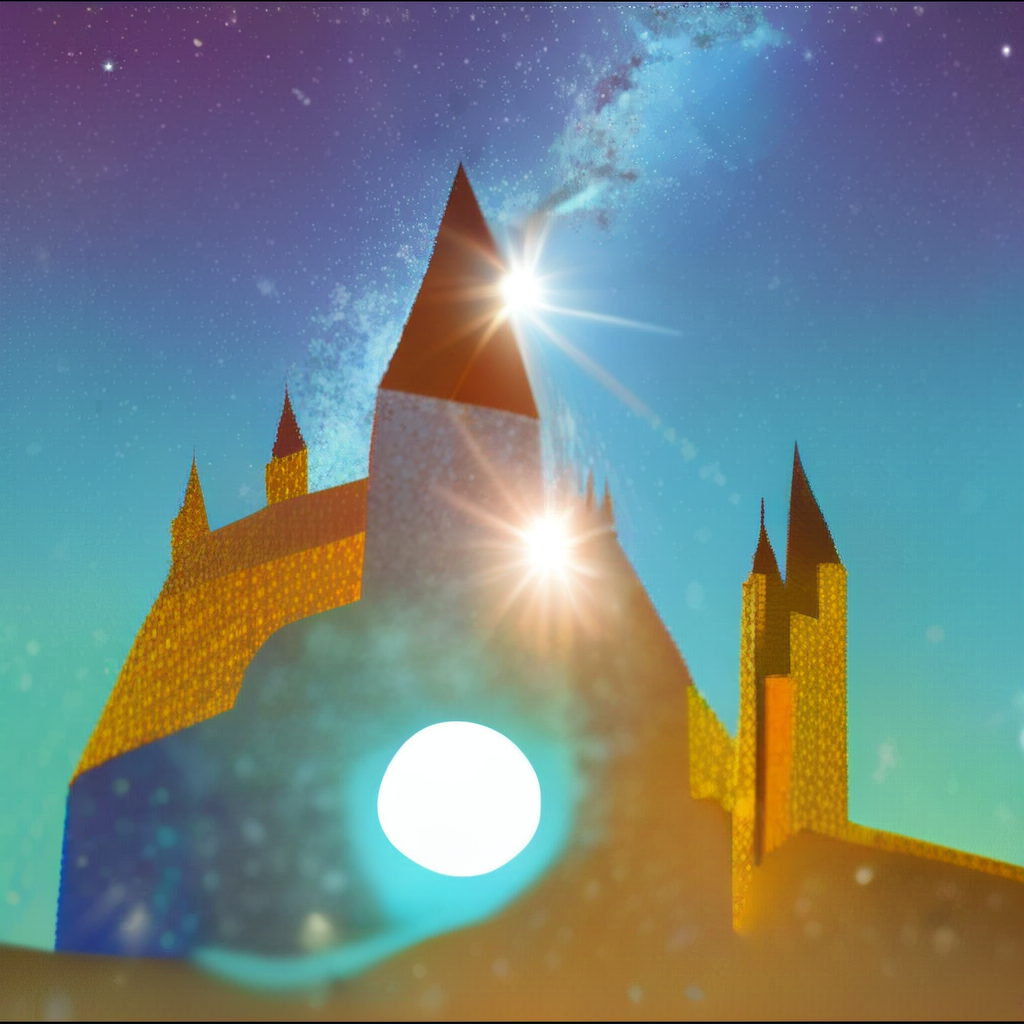

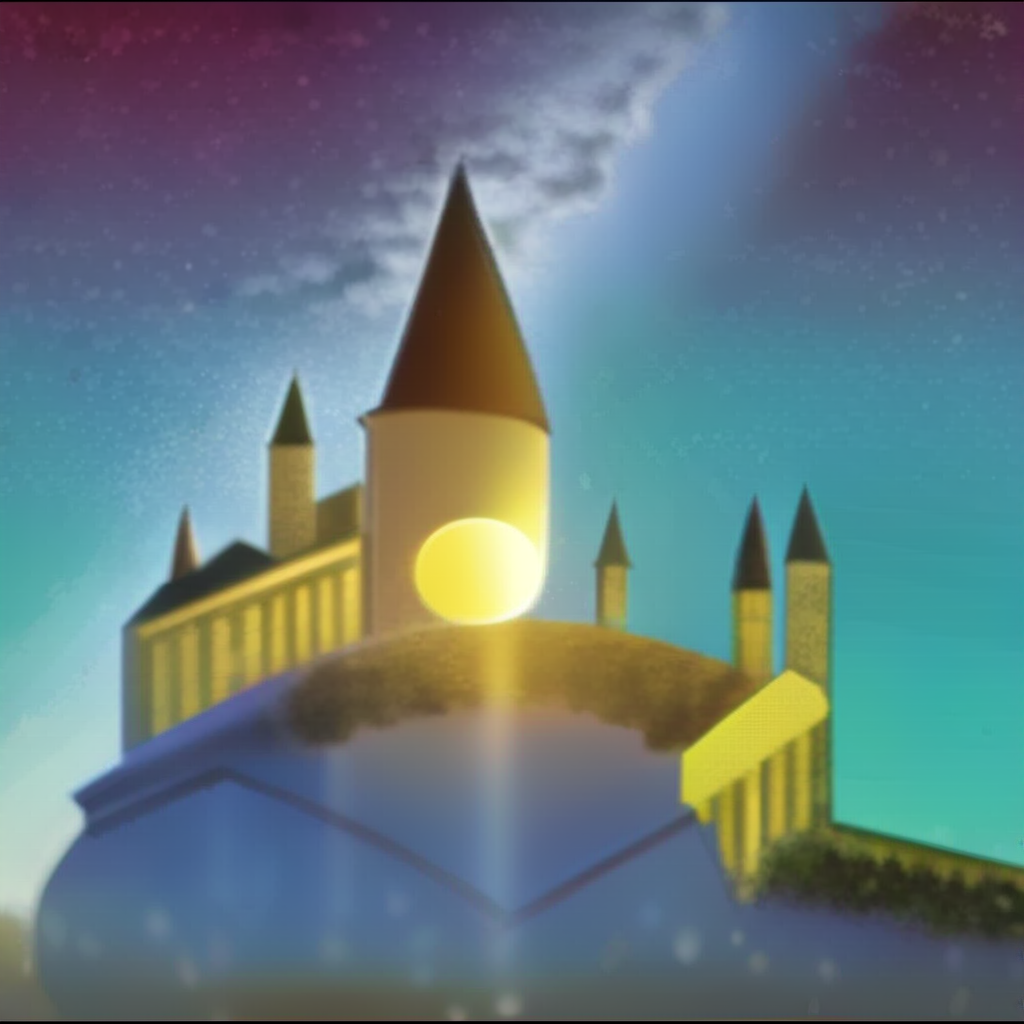

In [49]:
import vertexai
from vertexai.preview.vision_models import Image, ImageGenerationModel

model = ImageGenerationModel.from_pretrained("imagegeneration@002")
# base_img=Image.load_from_file(location='./images/tiger-512/00000000_512resized.png')
base_img=Image.load_from_file(location='./images/tiger-modified/gen-imagen.png')



images = model.edit_image(
  base_image=base_img,
  prompt="add sun",
  # negativePrompt = "red colour",
  # Optional:
  seed=0,
  guidance_scale=21,
  number_of_images=4
)

images[0].save(location="./images/tiger-modified/edit-sun-img1.png")
images[1].save(location="./images/tiger-modified/edit-sun-img2.png")
images[2].save(location="./images/tiger-modified/edit-sun-img3.png")
# images[3].save(location="./images/tiger-modified/edit-img4.png")

# Optional. View the edited images in a notebook.
images[0].show()
images[1].show()